**BUG** Bounding Boxes passen glaube ich in den Daten nicht fuer den Top View

**TODO** Anpassen der Aufloesung auf 1920x1080

**TODO** Hinzufuegen von Peds

**TODO** Hinzufuegen 2 Wheelers (need to fix the carla bug with bbox extent. Maybe dummy value. GCP is fine however!)

**TODO** Datenmenge und Variety 

**TODO** Vielleicht unsere Szenarien nachbilden? (Aufgabe fuer Alex?)

# Make Dataset

In [6]:
import random 
import pickle
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

def is_vehicle_out_of_bounds(gcp, w=640, h=480):
    x, y = gcp
    if x > w or x < 0 or y > h or y < 0:
        return True
    return False

def get_vehicles_from_ts(data, ts):
    return data[ts]

def get_vehicles_from_random_ts(data):
    idx_ts = random.choice(list(data.keys()))
    return idx_ts, data[idx_ts]

def filter_vehicles_not_in_img(data, w=640, h=480):
    return [vehicle for vehicle in data if not is_vehicle_out_of_bounds(vehicle['gcp'], w, h)]

def get_random_vehicle(data):
    idx = random.randint(0, len(data)-1)
    return data[idx]

def get_vehicles_from_ts(data, ts):
    return data[ts]

def get_vehicle_ids(data):
    return [vehicle['id'] for vehicle in data]

def filter_tv_vehicles(data, vehicle_ids):
    return [vehicle for vehicle in data if vehicle['id'] in vehicle_ids]

def cut_mask(bb, image):
    bb2d = bb_to_2d(np.array(bb))
    xmin, ymin, xmax, ymax = bb2d
    image_cropped = np.asarray(image)[ymin:ymax, xmin:xmax]
    return image_cropped

def get_mask(bb, image_cropped, image_seg):
    rgba, counts = np.unique(image_cropped.reshape(-1,4), axis=0, return_counts=True)
    # Filter street
    mask = ~np.all(rgba == np.array([1, 94, 110, 255]), axis=1)
    rgba = rgba[mask]
    counts = counts[mask]
    target_value = rgba[np.argmax(counts)]
    mask = np.all(np.asarray(image_seg) == target_value, axis=-1)
    return mask

def get_hull(mask):
    object_pixels = np.column_stack(np.where(mask))
    hull = cv2.convexHull(object_pixels)
    hull = hull.squeeze()
    return hull

def bb_to_2d(bb):
    x_min, x_max = np.min(bb[:, 0]), np.max(bb[:, 0])
    y_min, y_max = np.min(bb[:, 1]), np.max(bb[:, 1])
    return x_min, y_min, x_max, y_max

def plot_2d_box(bb):
    x_min, y_min, x_max, y_max = bb_to_2d(bb)
    plt.plot([x_min, x_min], [y_min, y_max], color='red')
    plt.plot([x_max, x_max], [y_min, y_max], color='red')
    plt.plot([x_min, x_max], [y_min, y_min], color='red')
    plt.plot([x_min, x_max], [y_max, y_max], color='red')

def plot_3d_box(bb):
    edges = [[0,1], [1,3], [3,2], [2,0], [0,4], [4,5], [5,1], [5,7], [7,6], [6,4], [6,2], [7,3]]
    for edge in edges:
        plt.plot(bb[edge, 0], bb[edge, 1], color='blue')

def plot_gcp(gcp):
    _ = plt.scatter(gcp[0], gcp[1], color='cyan', marker='*', s=30)

def plot_psi(gcp, psi):
    x, y = gcp
    x2, y2 = psi
    _ = plt.plot([x, x2], [y, y2], color='red', lw=2)

def plot_hull(hull):
    plt.plot(hull[:, 1], hull[:, 0], color='orange')

def append_hull(base_url, data):
    fname = base_url+data[0]['img']
    fname_seg = base_url + 'output/seg/' + fname.split('/')[-1]
    image = Image.open(fname)
    image_seg = Image.open(fname_seg)
    
    #_ = plt.imshow(image)
    #_ = plt.imshow(image_seg)
    for vehicle in data:
        image_cropped = cut_mask(vehicle['bb'], image_seg)
        mask = get_mask(vehicle['bb'], image_cropped, image_seg)
        hull = get_hull(mask)
        vehicle['hull'] = hull
    return data

def append_min_area_rect(data):
    for vehicle in data:
        min_area_rect = cv2.minAreaRect(vehicle['hull']) # Maybe need rotation
        box = cv2.boxPoints(min_area_rect)
        box = np.intp(box)
        #box = np.vstack((box, box[0, :]))
        vehicle['min_area_rect'] = box
    return data

def plot_min_area_rect(box):
    box = np.vstack((box, box[0, :]))
    plt.plot(box[:, 1], box[:, 0], color='cyan')

def get_data(ts, base_url='./', w=640, h=480):
    # Load Pickle Data
    with open(base_url + 'output/pv/data.pickle', 'rb') as handle:
        data_pv = pickle.load(handle)

    with open(base_url + 'output/tv/data.pickle', 'rb') as handle:
        data_tv = pickle.load(handle)

    # Perspective View
    vehicles_at_ts = get_vehicles_from_ts(data_pv, ts)
    vehicles_at_ts_filtered = filter_vehicles_not_in_img(vehicles_at_ts, w, h)
    vehicles_pv = append_hull(base_url, vehicles_at_ts_filtered)
    vehicles_pv = append_min_area_rect(vehicles_at_ts_filtered)
    fname_pv = base_url + vehicles_at_ts_filtered[0]['img']
    image_pv = Image.open(fname_pv)
    
    # Top View
    vehicles_at_ts_tv = get_vehicles_from_ts(data_tv, ts)
    v_ids = get_vehicle_ids(vehicles_pv)
    vehicles_tv = filter_tv_vehicles(vehicles_at_ts_tv, v_ids)
    fname_tv = base_url+vehicles_tv[0]['img']
    image_tv = Image.open(fname_tv)
    
    return image_pv, image_tv, vehicles_pv, vehicles_tv
ts = 34

image_pv, image_tv, vehicles_pv, vehicles_tv = get_data(ts, "../datasets/carla_dataset/")

# Plot Dataset

## Perspective View

We chose a random timestep and get the vehicles at this timestep. Additionally, we filter all vehicles, that are out of bounds. Finally, we enhance the data by appending a convex hull to each vehicle. Note that the methodology of the convex hull is not correct, if the vehicle is occluded by more than 50%. For each road user, you can visualize:
- 3d box
- 2d box
- gcp (ground contact point)
- psi vector (img coordinates)
- hull

However, carla has currently a bug for 2 wheelers, which is why they have no correct bounding boxes, hence also no convex hull. However, the gcp and psi vector are working fine.

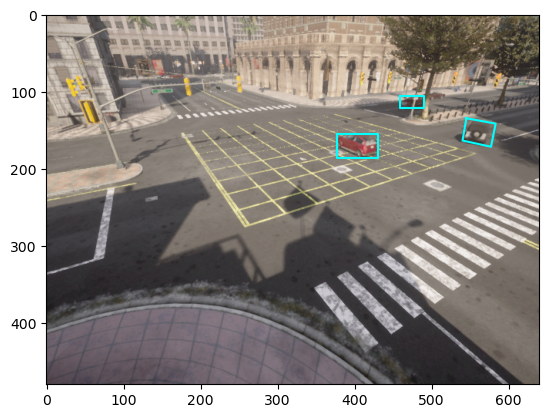

In [8]:
_ = plt.imshow(image_pv)
for vehicle in vehicles_pv:
    #plot_3d_box(np.array(vehicle['bb']))
    #plot_2d_box(np.array(vehicle['bb']))
    #plot_gcp(vehicle['gcp'])
    #plot_psi(vehicle['gcp'], vehicle['psi'])
    #plot_hull(vehicle['hull'])
    #print(vehicle["hull"])
    plot_min_area_rect(vehicle['min_area_rect'])

## Top View

The top View Values are dependent on the perspective view above. If cars are in the perspective view, then they are *searched* in the top-view.

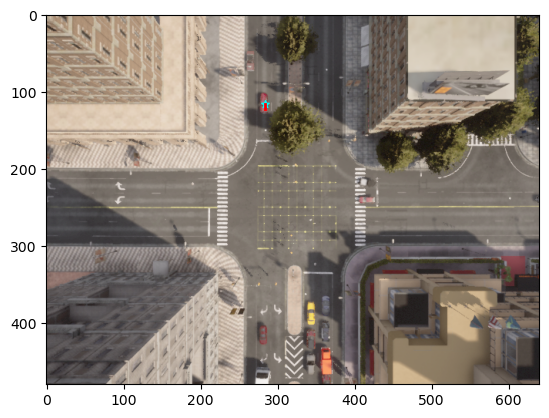

In [3]:
_ = plt.imshow(image_tv)
for vehicle in vehicles_tv:
    #plot_3d_box(np.array(vehicle['bb']))
    #plot_2d_box(np.array(vehicle['bb']))
    plot_gcp(vehicle['gcp'])
    plot_psi(vehicle['gcp'], vehicle['psi'])
    #plot_hull(vehicle['hull'])